# Table of Contents

1. [Density Grid from FFT_DATA](#fft)<br>
2. [Density Grid from Particle Positions](#pmesh)<br>

### This notebook shows how to calculate density fields from Indra data on the SciServer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import indratools as indra
from pmesh.window import CIC
from pmesh.window import Affine

In [2]:
boxlen = 1000.
npart = 1024
runnum = 205 # pick an Indra volume number, between 128 (2_0_0) and 447 (6_7_7) (for now)

In [3]:
# For fun, what is the X,Y,Z of this run?
indra.get_xyz(runnum)

(3, 1, 5)

# 1. Density Grid from FFT Data
<a id="fft"></a>

A coarse grid of the Fourier modes of the density field are saved as the simulation runs at 505 time steps. These can be inverse Fourier transformed to obtain a 128x128x128 grid of the density field.

In [4]:
redshift = .5
fft_snaps,fft_redshifts,fft_times = indra.FFT_snapinfo()
tnum = (np.abs(fft_redshifts - redshift)).argmin() # snapshot closest to desired redshift
L = 128 # dimensions of FFT grid
L2 = L//2
ind_kxky = np.concatenate((np.arange(L2,L+1),np.arange(1,L2)))

First we need to re-index the Indra FFT arrays to correspond to the *k* values expected by `np.fft`.

In [5]:
kxi,kyi,kzi = indra.getkvals()

In [6]:
kmin = 2.*np.pi/boxlen
kx = kxi[np.ix_(ind_kxky,ind_kxky)]
ky = kyi[np.ix_(ind_kxky,ind_kxky)]
kz = kzi[np.ix_(ind_kxky,ind_kxky)]
k = kmin*np.sqrt(kx**2+ky**2+kz**2)

In [7]:
fft_re,fft_im,a = indra.getfft(runnum,tnum)

In [8]:
fft_re = fft_re[np.ix_(ind_kxky,ind_kxky)]
fft_im = fft_im[np.ix_(ind_kxky,ind_kxky)]

Now we can inverse Fourier transform to get the density grid.

In [9]:
dk = np.zeros(fft_re.shape,dtype=complex)
dk.real = fft_re
dk.imag = fft_im
dk *= L**3/npart**3 # normalization

In [10]:
dens = np.fft.ifftn(dk,s=(L,L,L))
delta = np.sqrt(dens.real*dens.real+dens.imag*dens.imag)

Let's plot a slice!

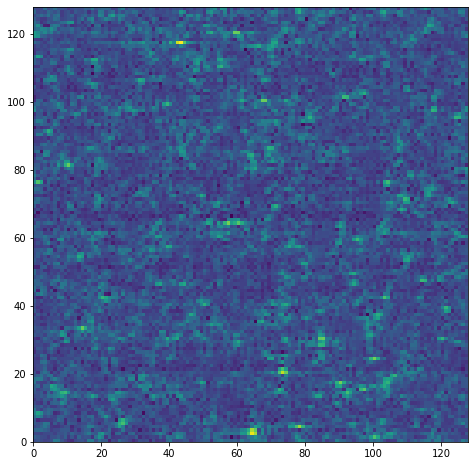

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(delta[30]+1),origin='lower',extent=(0,L,0,L))
plt.xlim(0,L)
plt.ylim(0,L);

# 2. Density Grid from Particle Positions
<a id="pmesh"></a>

The density field can also be measured directly from the particle positions, at higher resolution than the FFT grid, using the public package [pmesh](https://github.com/rainwoodman/pmesh). In this example we will choose a Cloud-In-Cell interpolation.

In [12]:
snapnum = 41 # z = 1
ngrid = 256
cell_len = np.float64(boxlen)/np.float64(ngrid)

In [13]:
pos = indra.getpos(runnum,snapnum)

In [14]:
mesh = np.zeros((ngrid,ngrid,ngrid))
posnorm = pos/cell_len # normalize positions

In [15]:
affine = Affine(ndim=3, period=ngrid) # takes care of periodic boundary conditions
CIC.paint(mesh,posnorm,transform=affine)

In [16]:
meanden = np.mean(mesh.flatten())
delta = mesh/meanden-1

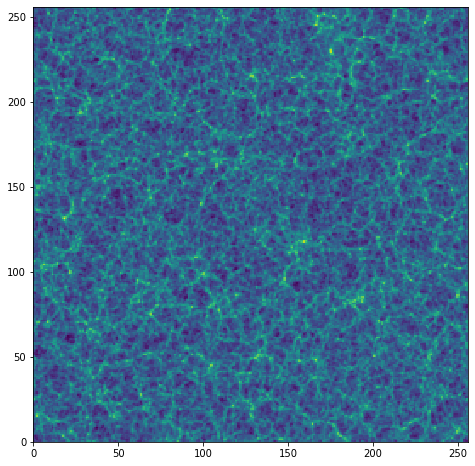

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(delta[0]+1),origin='lower',extent=(0,ngrid,0,ngrid))
# Note that this puts z on x-axis and y on y-axis
plt.xlim(0,ngrid)
plt.ylim(0,ngrid);

pmesh has a few other window functions, including Triangular-Shaped-Cloud (see the pmesh [documentation](https://github.com/rainwoodman/pmesh)).

In [18]:
from pmesh.window import TSC
tmesh = np.zeros((ngrid,ngrid,ngrid))
TSC.paint(tmesh,posnorm,transform=affine)

In [19]:
delta_tsc = tmesh/np.mean(tmesh) - 1

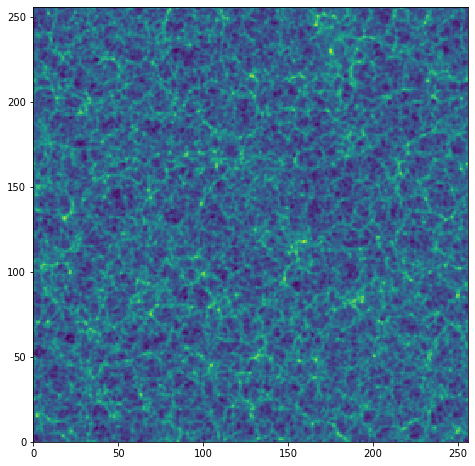

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(delta_tsc[0]+1),origin='lower',extent=(0,ngrid,0,ngrid))
plt.xlim(0,ngrid)
plt.ylim(0,ngrid);